# prepare

## git clone

In [ ]:
!git clone https://github.com/kc71486/autonomous_homework.git

Cloning into 'autonomous_homework'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 48 (delta 0), reused 3 (delta 0), pack-reused 45
Receiving objects: 100% (48/48), 80.61 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%cd autonomous_homework/hw2

/content/autonomous_homework/hw2/autonomous_homework/hw2


## pip install

In [ ]:
!pip install matplotlib

In [ ]:
!pip install moviepy

In [ ]:
!pip install ffmpeg

# main

## import

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import linalg
import cv2

import math
import os

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## helper functions

In [ ]:
def get_point_line_dist(line, point):
    p1 = np.array(line[0]);
    p2 = np.array(line[1]);
    p3 = np.array(point);
    return abs(np.cross(p2-p1,p3-p1)/linalg.norm(p2-p1));

def point_dist(point1, point2):
    x1 = point1[0];
    y1 = point1[1];
    x2 = point2[0];
    y2 = point2[1];
    return abs((x2 - x1) ** 2 + (y2 - y1) ** 2);

def scalewidth(img, beforescale):
    return int(beforescale*(img.shape[0]/1000.0))

def ratio_to_coord(img, ratio=[0, 0]):
    xsize = img.shape[1];
    ysize = img.shape[0];
    return [int(xsize*ratio[0]), int(ysize*ratio[1])];

def rgbscale(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img);

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count;
    else:
        ignore_mask_color = 255;

    # filling pixels inside the polygon defined by "vertices" with the fill color
    # added [] in vertices
    cv2.fillPoly(mask, vertices, ignore_mask_color);

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask);
    return masked_image

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

def filter_lines(lines: np.ndarray, predicate):
    newlines = []
    for line in lines:
        x1,y1,x2,y2 = line;
        if predicate(x1, y1, x2, y2):
            newlines.append(line)
    return np.array(newlines);

def extend_lines(lines: np.ndarray, imgheight: int):
    newlines = np.copy(lines);
    newlines = [];
    for line in lines:
        x1,y1,x2,y2 = line;
        xnorm = (x1 + x2) / 2;
        ynorm = (y1 + y2) / 2;
        extend_ratio = imgheight / abs(y1 - y2);

        x1 = int(xnorm +  (x1 - x2) / 2 * extend_ratio);
        x2 = int(xnorm -  (x1 - x2) / 2 * extend_ratio);
        y1 = int(ynorm +  (y1 - y2) / 2 * extend_ratio);
        y2 = int(ynorm -  (y1 - y2) / 2 * extend_ratio);
        newlines.append([x1, y1, x2, y2]);
    return np.array(newlines);

def draw_line(img, line, thickness = 6):
    if line.shape[0] == 0:
        return
    x1,y1,x2,y2 = line;
    cv2.line(img, (x1, y1), (x2, y2), [255], thickness);

## lane finding algirithm

In [ ]:
def process_image(img):
    # change type into int8 if not already
    # only trigger if type is float and < 1
    if img[0][0][0] > 0 and img[0][0][0] < 1:
        img = np.uint8(img * 255);

    # change rgba into rgb
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # map into higher contrast grayscale image
    img_red = img[:, :, 0].astype(float);
    img_green = img[:, :, 1].astype(float);
    img_blue = img[:, :, 2].astype(float);
    grayimg = (img_red * 3 + img_green * 3 + img_blue * 1) / 7;
    grayimg = grayimg.astype(np.uint8);

    # canny edge detection
    blur_gray = gaussian_blur(grayimg, 3);
    low_threshold = 30;
    high_threshold = 90;
    edges = canny(blur_gray, low_threshold, high_threshold);

    # apply region of interest onto edge detected image
    left = ratio_to_coord(img, [0.0, 0.95]);
    right = ratio_to_coord(img, [1.0, 0.95]);
    left_bottom = ratio_to_coord(img, [0.0, 1.0]);
    right_bottom = ratio_to_coord(img, [1.0, 1.0]);
    left_top = ratio_to_coord(img, [0.4, 0.65]);
    right_top = ratio_to_coord(img, [0.6, 0.65]);
    vertices = np.array([[left_bottom, left, left_top, right_top, right, right_bottom]])
    masked_edges = region_of_interest(edges, vertices);

    # hough transform line detection
    rho = 1;
    theta = np.pi/180;
    threshold = scalewidth(img, 19);
    minLineLength = 12;
    max_line_gap = 3;
    thickness = 6;
    minslope = 0.4;
    center = ratio_to_coord(img, [0.5, 0.6]);
    maxoffcenter = img.shape[0]*0.05;

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            minLineLength=minLineLength, maxLineGap=max_line_gap);
    lines = np.squeeze(lines, axis=1);

    line_img = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)

    # line filter + extension
    lines_left = [];
    lines_right = [];
    weight_left = [];
    weight_right = [];
    for line in lines:
        x1,y1,x2,y2 = line;
        slope = (y1 - y2)/(x1 - x2);
        cond_left = slope >= 0.4 and slope <= 4;
        cond_right = slope <= -0.4 and slope >= -4;
        cond_offcenter = get_point_line_dist([[x1, y1], [x2, y2]], center) < maxoffcenter;

        if cond_left and cond_offcenter:
            y1 = int(y1 - x1 * slope);
            y2 = int(y2 + (img.shape[1] - x2) * slope);
            lines_left.append([0, y1, img.shape[1], y2]);
            weight_left.append(point_dist((x1, y1), (x2, y2)))
        if cond_right and cond_offcenter:
            y1 = int(y1 - x1 * slope);
            y2 = int(y2 + (img.shape[1] - x2) * slope);
            x1 = int(0);
            x2 = int(img.shape[1]);
            lines_right.append([0, y1, img.shape[1], y2]);
            weight_right.append(point_dist((x1, y1), (x2, y2)))

    lines_left =  np.array(lines_left);
    lines_right =  np.array(lines_right);
    if lines_left.shape[0] > 0:
        line_left = np.average(lines_left, weights=weight_left, axis=0).astype(int);
        draw_line(line_img, line_left, thickness=thickness);
        #for line in lines_left:
        #    draw_line(line_img, line, thickness=thickness);
    if lines_right.shape[0] > 0:
        line_right =  np.average(lines_right, weights=weight_right, axis=0).astype(int);
        draw_line(line_img, line_right, thickness=thickness);
        #for line in lines_right:
        #    draw_line(line_img, line, thickness=thickness);

    # apply region of interest onto lane line image
    left = ratio_to_coord(img, [0.0, 0.95]);
    right = ratio_to_coord(img, [1.0, 0.95]);
    left_bottom = ratio_to_coord(img, [0.0, 1.0]);
    right_bottom = ratio_to_coord(img, [1.0, 1.0]);
    left_top = ratio_to_coord(img, [0.4, 0.6]);
    right_top = ratio_to_coord(img, [0.6, 0.6]);
    vertices = np.array([[left_bottom, left, left_top, right_top, right, right_bottom]])
    masked_line_image = region_of_interest(line_img, vertices);

    colored_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8);
    colored_image[:, :, 0] = np.copy(masked_line_image);

    final_img = weighted_img(colored_image, img);
    return final_img;

## Process sample image

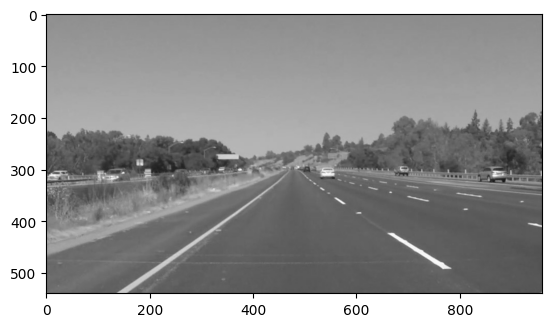

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg');
if image[0][0][0] > 0 and image[0][0][0] < 1:
    image = np.uint8(image * 255);
img_red = image[:, :, 0].astype(float);
img_green = image[:, :, 1].astype(float);
img_blue = image[:, :, 2].astype(float);
grayimg = (img_red * 3 + img_green * 3 + img_blue * 1) / 7;
grayimg = grayimg.astype(np.uint8);
grayimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2RGB);
#printing out some stats and plotting
plt.imshow(grayimg);

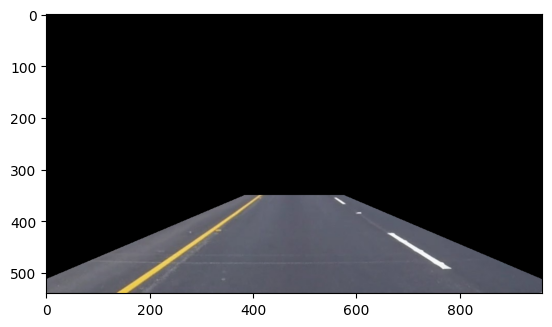

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg');
if image[0][0][0] > 0 and image[0][0][0] < 1:
    image = np.uint8(image * 255);
left = ratio_to_coord(image, [0.0, 0.95]);
right = ratio_to_coord(image, [1.0, 0.95]);
left_bottom = ratio_to_coord(image, [0.0, 1.0]);
right_bottom = ratio_to_coord(image, [1.0, 1.0]);
left_top = ratio_to_coord(image, [0.4, 0.65]);
right_top = ratio_to_coord(image, [0.6, 0.65]);
vertices = np.array([[left_bottom, left, left_top, right_top, right, right_bottom]])
masked = region_of_interest(image, vertices);
#printing out some stats and plotting
plt.imshow(masked);

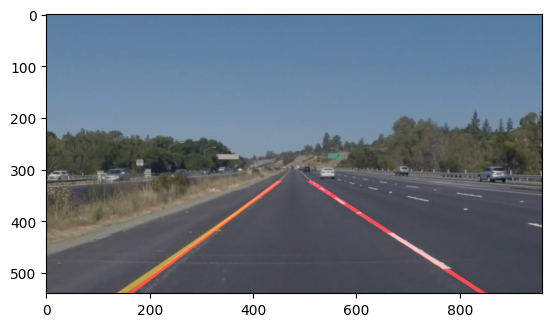

In [ ]:
newimage = process_image(image)
plt.imshow(newimage, cmap='Greys_r')

## convert video

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 5.15 s, sys: 478 ms, total: 5.63 s
Wall time: 14.6 s


In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 16.7 s, sys: 1.7 s, total: 18.4 s
Wall time: 46.4 s


In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip1.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



t:  56%|█████▌    | 140/251 [00:16<00:15,  7.23it/s, now=None]WARNING:py.warnings:<ipython-input-245-1ee6ee913b4f>:58: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (y1 - y2)/(x1 - x2);



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 15.6 s, sys: 1.01 s, total: 16.6 s
Wall time: 39.1 s


In [ ]:
another_output = 'test_videos_output/another.mp4'
clip1 = VideoFileClip("test_videos/another.mp4")
another_clip = clip1.fl_image(process_image)
%time another_clip.write_videofile(another_output, audio=False)

  slope = (y1 - y2)/(x1 - x2);



Moviepy - Building video test_videos_output/another.mp4.
Moviepy - Writing video test_videos_output/another.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/another.mp4
CPU times: user 47.1 s, sys: 3.94 s, total: 51.1 s
Wall time: 1min 47s


In [ ]:
#not supported in any of my browser though
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## git commit and push

In [ ]:
#manual upload file
f = open("../remotepath.txt", "r");
remote_path = f.readline();
git_username = f.readline();
git_email = f.readline();

In [ ]:
!git config --global user.email {git_email}
!git config --global user.name {git_username}
!git remote set-url origin {remote_path}

In [ ]:
!git add "test_videos_output/solidWhiteRight.mp4"
!git add "test_videos_output/solidYellowLeft.mp4"
!git add "test_videos_output/challenge.mp4"
!git add "test_videos_output/another.mp4"

In [ ]:
!git commit -m "add/modify videos in test_videos_output"

[main 5e95773] add/modify videos in test_videos_output
 4 files changed, 0 insertions(+), 0 deletions(-)
 rewrite test_videos_output/solidWhiteRight.mp4 (80%)
 rewrite test_videos_output/solidYellowLeft.mp4 (61%)


In [ ]:
!git push origin main

Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 19.26 MiB | 13.64 MiB/s, done.
Total 7 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/kc71486/autonomous_hw2.git
   3a6c80a..5e95773  main -> main
